Copyright 2020 Google Inc. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); <br>
you may not use this file except in compliance with the License.<br>
You may obtain a copy of the License at<br>

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.<br>

See the License for the specific language governing permissions and 
limitations under the License.

In [6]:
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

In [44]:
with open("compression_results_12000.json") as file:
    json_res = json.loads(file.read())

In [46]:
def to_vector(json_data, take_unbundled, algorithms):
    result = []
    approaches = ["bundled"]
    if take_unbundled:
        approaches.append("unbundled")
    attributes = ["_compression_rate", "_speed"] 
    for attr in attributes:
        for approach in approaches:
            for alg in algorithms:
                result.append(json_data[approach][alg + attr])
    return np.array(result)
    
# for applying smoothing of the data as data is noisy
def to_range_number(number, range_size):
    return number // range_size

## By chunks

In [56]:
def get_rates_by_chunks(data, range_size, take_unbundled=True, 
                        algorithms=["brotli11", "brotli9", "brotli6", "zlib9"]):
    
    chunks_to_ind = defaultdict(list)
    for i in range(len(data)):
        if "'chunks_count': 0" not in str(data[i]) and "{'chunks_execution_result': 0}" not in str(data[i]):
            chunks_to_ind[to_range_number(data[i]["chunks_count"], range_size)].append(i)
    
    mean_size = 2 * len(algorithms)
    if take_unbundled:
        mean_size *= 2
    chunks_to_mean = dict()
    for chunk in chunks_to_ind:
        rates = []
        for i in chunks_to_ind[chunk]:
            rates.append(to_vector(data[i], take_unbundled, algorithms))
        mean = np.zeros(mean_size)
        rates = np.array(rates)
        for i in range(mean_size):
            #filter outliers
            if len(rates[:,i]) <= 2:
                mean[i] = np.mean(rates[:,i])
            else:
                mean[i] = np.mean(np.sort(rates[:,i])[1:-1])
        chunks_to_mean[chunk] = mean

    all_chunks = []
    for chunk in chunks_to_mean:
        all_chunks.append(chunk)
    all_chunks = np.sort(all_chunks)
    return chunks_to_mean, all_chunks

### Small chunks number

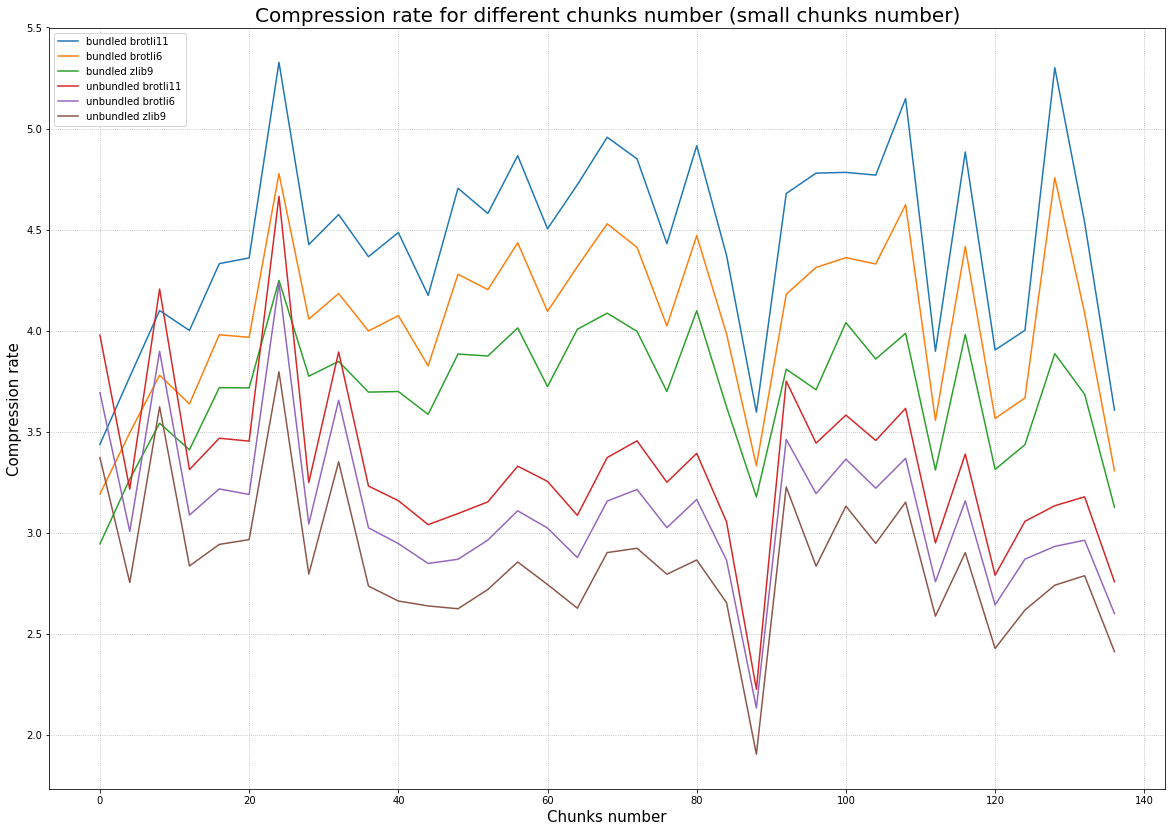

In [74]:
names = ["bundled brotli11", "bundled brotli6", "bundled zlib9",
         "unbundled brotli11", "unbundled brotli6", "unbundled zlib9"]

range_smoothing_size = 4
chunks_to_mean, all_chunks = get_rates_by_chunks(json_res, range_smoothing_size, take_unbundled=True, 
                                                 algorithms=["brotli11", "brotli6", "zlib9"])

plt.figure(figsize=(20, 14))
for i, feat in enumerate(np.arange(6)):
    line = []
    for chunk in all_chunks:
        line.append(chunks_to_mean[chunk][feat])
    plt.plot(np.array(all_chunks[:35]) * range_smoothing_size, line[:35], label=names[i])
    
plt.legend()
plt.grid(ls=":")
plt.xlabel("Chunks number", fontsize=15)
plt.ylabel("Compression rate", fontsize=15)
plt.title("Compression rate for different chunks number (small chunks number)", fontsize=20)
plt.show()

### All chunks

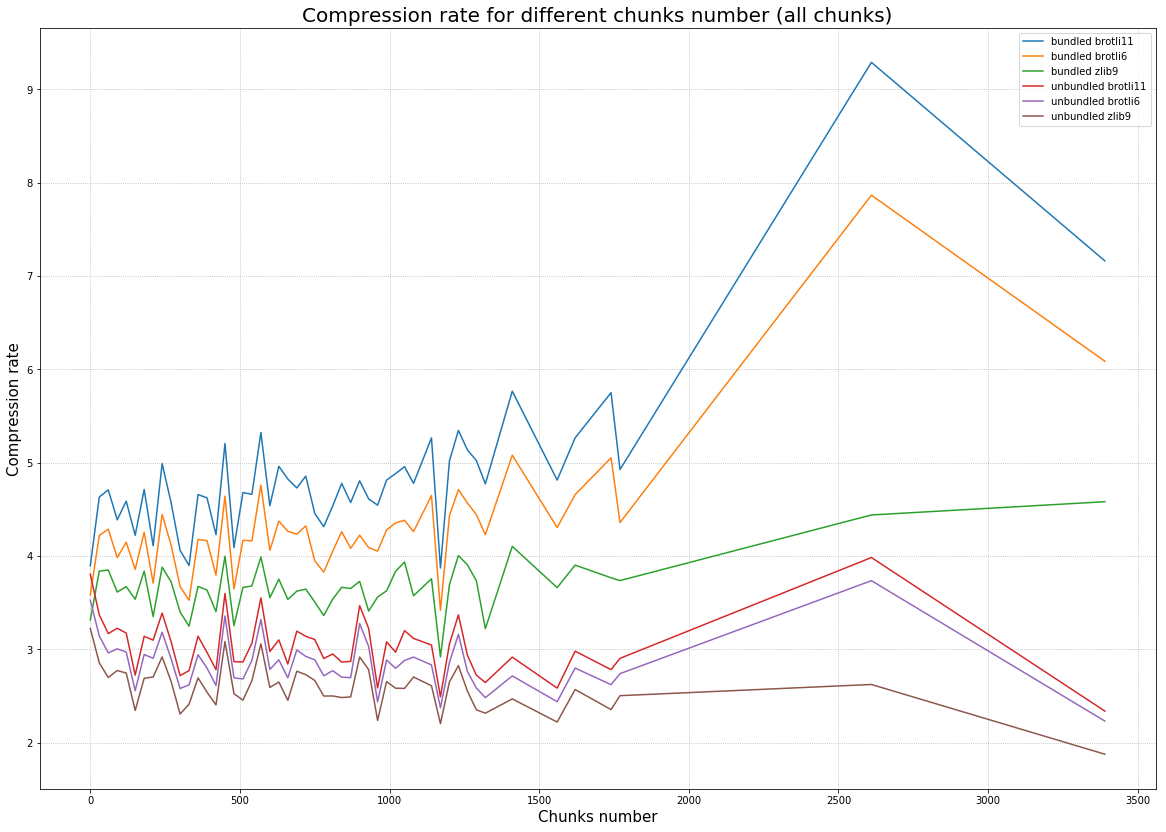

In [70]:
range_smoothing_size = 30
chunks_to_mean, all_chunks = get_rates_by_chunks(json_res, range_smoothing_size, take_unbundled=True, 
                                                 algorithms=["brotli11", "brotli6", "zlib9"])

plt.figure(figsize=(20, 14))
for i, feat in enumerate(np.arange(6)):
    line = []
    for chunk in all_chunks:
        line.append(chunks_to_mean[chunk][feat])
    plt.plot(np.array(all_chunks) * range_smoothing_size, line, label=names[i])
    
plt.legend()
plt.grid(ls=":")
plt.xlabel("Chunks number", fontsize=15)
plt.ylabel("Compression rate", fontsize=15)
plt.title("Compression rate for different chunks number (all chunks)", fontsize=20)
plt.show()

## SIZES

In [65]:
def get_rates_by_sizes(data, range_size, take_unbundled=True, 
                        algorithms=["brotli11", "brotli9", "brotli6", "zlib9"]):

    size_to_ind = defaultdict(list)
    for i in range(len(data)):
        if "'chunks_count': 0" not in str(data[i]) and "{'chunks_execution_result': 0}" not in str(data[i]):
            if data[i]["unbundled"]["brotli11_compression_rate"] > 10 or data[i]["bundled"]["brotli11_compression_rate"] > 10:
                continue
            size_to_ind[to_range_number(data[i]["original_size"], range_size)].append(i)

    mean_size = 2 * len(algorithms)
    if take_unbundled:
        mean_size *= 2
    size_to_mean = dict()
    for size in size_to_ind:
        rates = []
        for i in size_to_ind[size]:
            rates.append(to_vector(data[i], take_unbundled, algorithms))
        mean = np.zeros(mean_size)
        rates = np.array(rates)
        for i in range(mean_size):
            #filter outliers
            if len(rates[:,i]) <= 2:
                mean[i] = np.mean(rates[:,i])
            elif len(rates[:,i]) <= 4:
                mean[i] = np.mean(np.sort(rates[:,i])[1:-1])
            else:
                mean[i] = np.mean(np.sort(rates[:,i])[2:-2])
        size_to_mean[size] = mean

    all_sizes = []
    for size in size_to_mean:
        all_sizes.append(size)
    all_sizes = np.sort(all_sizes)

    return size_to_mean, all_sizes

### Small sizes

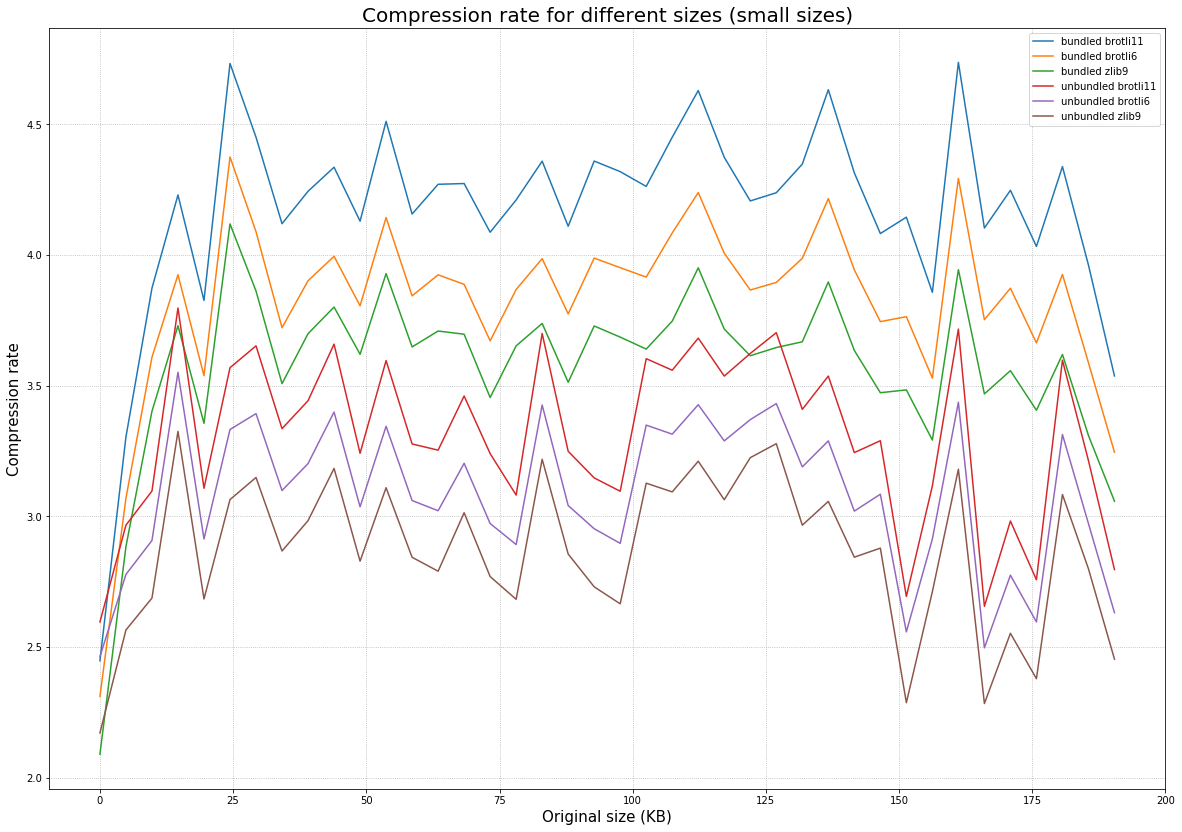

In [71]:
range_smoothing_size = 5000
size_to_mean, all_sizes = get_rates_by_sizes(json_res, range_smoothing_size, take_unbundled=True, 
                                             algorithms=["brotli11", "brotli6", "zlib9"])

plt.figure(figsize=(20, 14))
for i, feat in enumerate(np.arange(6)):
    line = []
    for size in all_sizes:
        line.append(size_to_mean[size][feat])
    plt.plot(np.array(all_sizes[:40]) * range_smoothing_size / 1024, line[:40], label=names[i])
    
plt.legend()
plt.grid(ls=":")
plt.xlabel("Original size (KB)", fontsize=15)
plt.ylabel("Compression rate", fontsize=15)
plt.title("Compression rate for different sizes (small sizes)", fontsize=20)
plt.show()

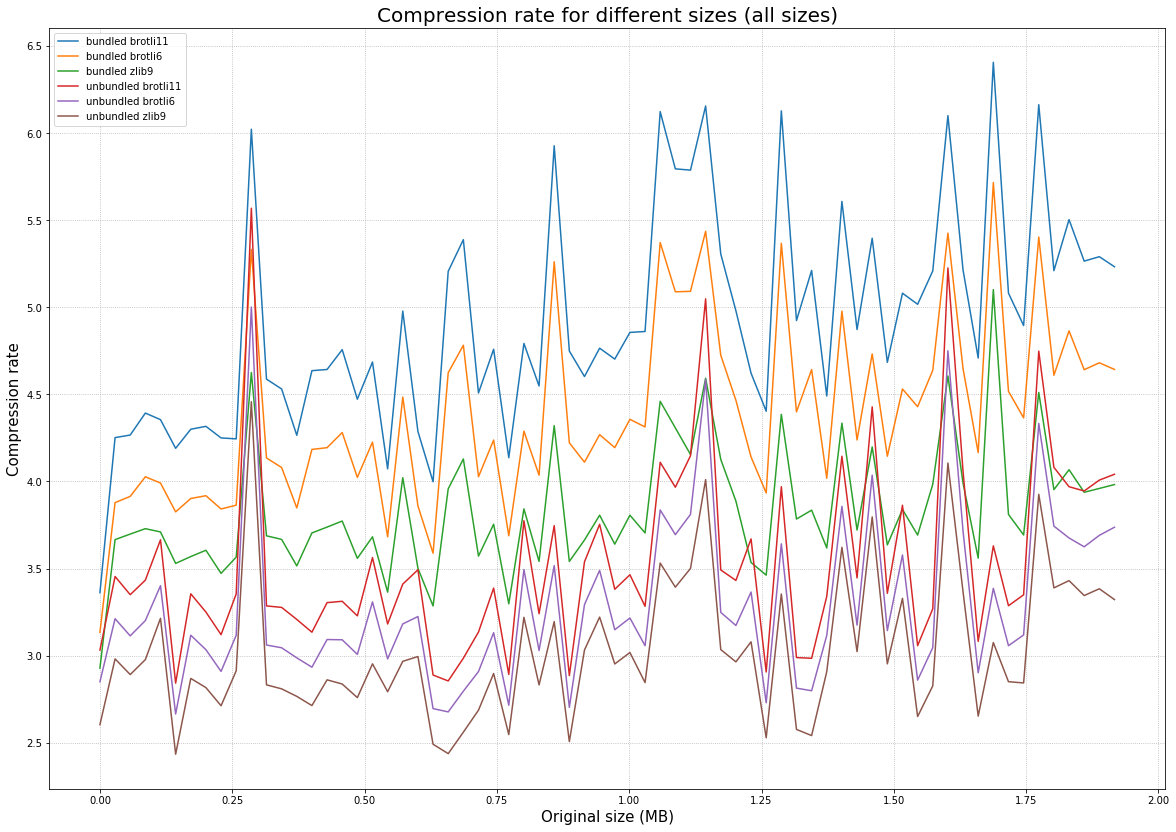

In [73]:
range_smoothing_size = 30000
size_to_mean, all_sizes = get_rates_by_sizes(json_res, range_smoothing_size, take_unbundled=True, 
                                             algorithms=["brotli11", "brotli6", "zlib9"])

plt.figure(figsize=(20, 14))
for i, feat in enumerate(np.arange(6)):
    line = []
    for size in all_sizes:
        line.append(size_to_mean[size][feat])
    plt.plot(np.array(all_sizes)[:-1] * range_smoothing_size / 1024 / 1024, line[:-1], label=names[i])
    
plt.legend()
plt.grid(ls=":")
plt.xlabel("Original size (MB)", fontsize=15)
plt.ylabel("Compression rate", fontsize=15)
plt.title("Compression rate for different sizes (all sizes)", fontsize=20)
plt.show()